In [2]:
import pandas as pd

In [3]:
load_data = pd.read_csv("data/Historical_Load_Data.csv")
holiday_list = pd.read_csv("data/Staff_List_with_Holidays.csv")

print (load_data.shape, holiday_list.shape)

(91, 5) (7, 3)


In [4]:
load_data.head()

,date,load_units,people_required,people_available,overtime
0,01-04-2025,10,10,7,True
1,02-04-2025,11,11,7,True
2,03-04-2025,9,9,7,True
3,04-04-2025,11,11,6,True
4,05-04-2025,3,3,7,False


In [23]:
load_data["date"].min(), load_data["date"].max()

(Timestamp('2025-04-01 00:00:00'), Timestamp('2025-06-30 00:00:00'))

In [5]:
holiday_list.head()

,employee_id,name,holidays
0,1,Alice,"2025-07-01,2025-06-16,2025-05-21,2025-05-08"
1,2,Bob,"2025-07-16, 2025-05-12,2025-05-06,2025-05-20"
2,3,Carol,"2025-07-07, 2025-06-07,2025-06-06,2025-06-27"
3,4,Dave,"2025-07-11,2025-04-29,2025-05-10,2025-05-11"
4,5,Eve,"2025-05-26,2025-06-02,2025-06-21,2025-08-11"


In [6]:
load_data.isna().sum()

date                0
load_units          0
people_required     0
people_available    0
overtime            0
dtype: int64

In [7]:
load_data[load_data["load_units"] != load_data["people_required"]]

,date,load_units,people_required,people_available,overtime


In [8]:
### there is no use of keeping both load units and people required as they have exactly the same values in each row

In [9]:
load_data["load_units"].describe()

count    91.000000
mean      8.098901
std       2.645982
min       3.000000
25%       6.000000
50%       8.000000
75%      10.000000
max      12.000000
Name: load_units, dtype: float64

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# Convert date column to datetime
load_data['date'] = pd.to_datetime(load_data['date'], format='%d-%m-%Y')
load_data = load_data.sort_values('date')

# Add time-based features for pattern analysis
load_data['day_of_week'] = load_data['date'].dt.day_name()
load_data['week_number'] = load_data['date'].dt.isocalendar().week
load_data['month'] = load_data['date'].dt.month
load_data['is_weekend'] = load_data['date'].dt.dayofweek >= 5

print("Data with time features:")
print(load_data.head())

Data with time features:
        date  load_units  people_required  people_available  overtime  \
0 2025-04-01          10               10                 7      True   
1 2025-04-02          11               11                 7      True   
2 2025-04-03           9                9                 7      True   
3 2025-04-04          11               11                 6      True   
4 2025-04-05           3                3                 7     False   

  day_of_week  week_number  month  is_weekend  
0     Tuesday           14      4       False  
1   Wednesday           14      4       False  
2    Thursday           14      4       False  
3      Friday           14      4       False  
4    Saturday           14      4        True  


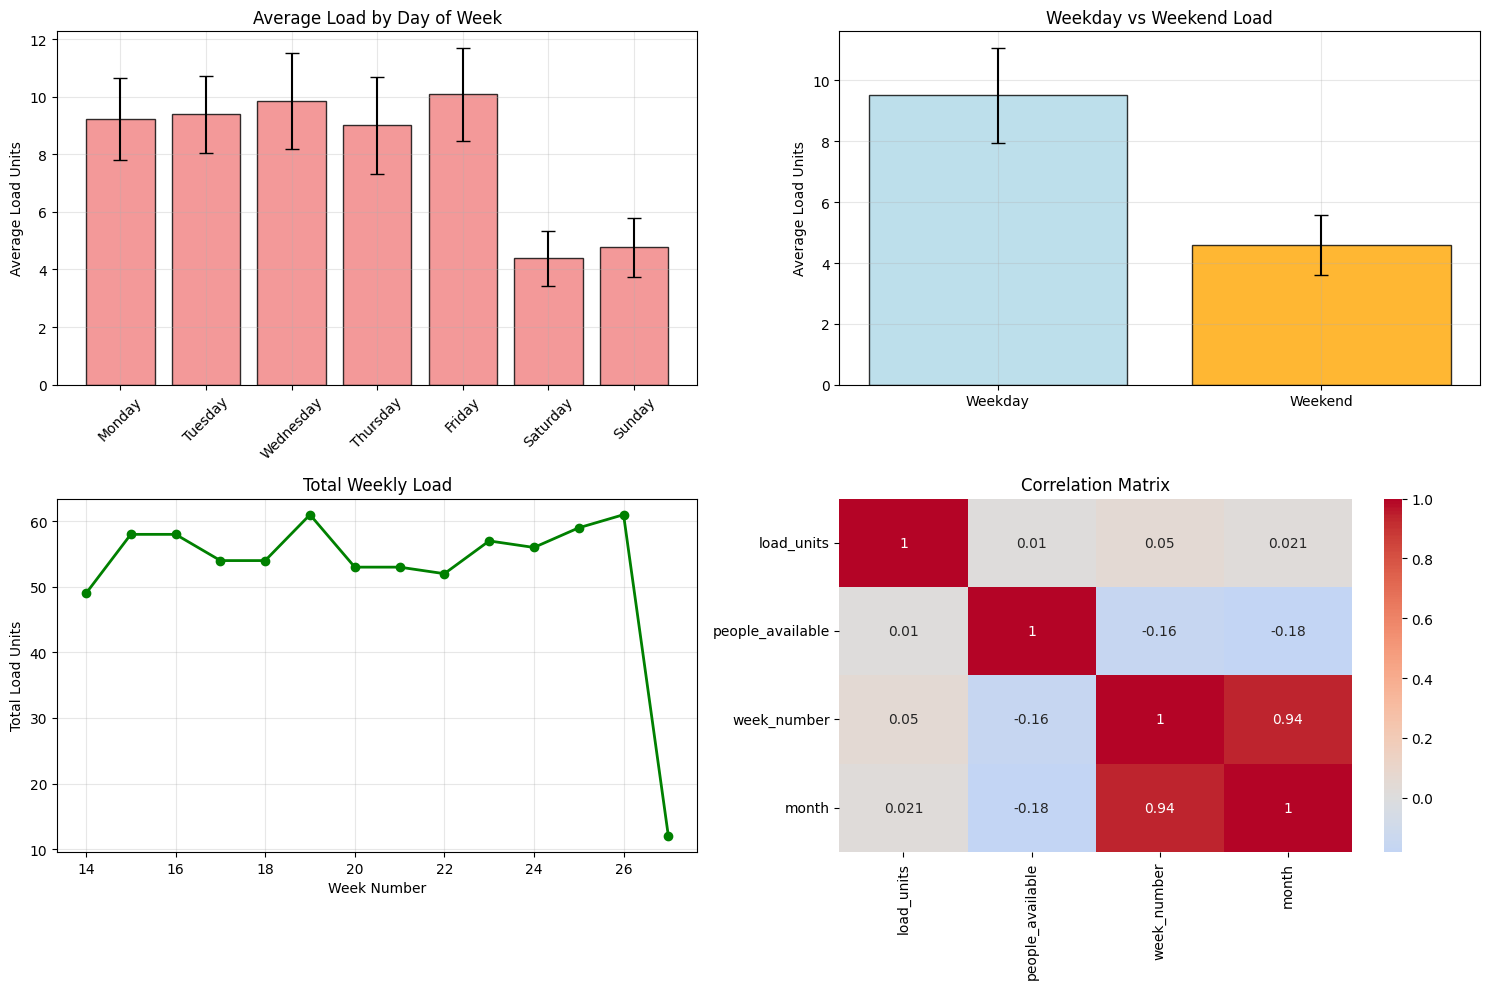

=== PATTERN INSIGHTS ===
Highest load day: Friday (10.1 avg)
Lowest load day: Saturday (4.4 avg)
Weekday avg: 9.5
Weekend avg: 4.6
Total weeks in data: 14
Weekly load range: 12-61 units


In [14]:
# Pattern Analysis - Day of week and weekly trends
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Load by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg = load_data.groupby('day_of_week')['load_units'].agg(['mean', 'std']).reindex(day_order)

axes[0,0].bar(daily_avg.index, daily_avg['mean'], yerr=daily_avg['std'], 
              capsize=5, color='lightcoral', alpha=0.8, edgecolor='black')
axes[0,0].set_title('Average Load by Day of Week')
axes[0,0].set_ylabel('Average Load Units')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# 2. Weekend vs Weekday comparison
weekend_data = load_data.groupby('is_weekend')['load_units'].agg(['mean', 'std', 'count'])
weekend_data.index = ['Weekday', 'Weekend']
axes[0,1].bar(weekend_data.index, weekend_data['mean'], yerr=weekend_data['std'],
              capsize=5, color=['lightblue', 'orange'], alpha=0.8, edgecolor='black')
axes[0,1].set_title('Weekday vs Weekend Load')
axes[0,1].set_ylabel('Average Load Units')
axes[0,1].grid(True, alpha=0.3)

# 3. Weekly aggregation
weekly_load = load_data.groupby('week_number')['load_units'].sum().reset_index()
axes[1,0].plot(weekly_load['week_number'], weekly_load['load_units'], 
               marker='o', linewidth=2, markersize=6, color='green')
axes[1,0].set_title('Total Weekly Load')
axes[1,0].set_xlabel('Week Number')
axes[1,0].set_ylabel('Total Load Units')
axes[1,0].grid(True, alpha=0.3)

# 4. Correlation matrix heatmap
corr_data = load_data[['load_units', 'people_available', 'week_number', 'month']].corr()
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
axes[1,1].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

print("=== PATTERN INSIGHTS ===")
print(f"Highest load day: {daily_avg['mean'].idxmax()} ({daily_avg['mean'].max():.1f} avg)")
print(f"Lowest load day: {daily_avg['mean'].idxmin()} ({daily_avg['mean'].min():.1f} avg)")
print(f"Weekday avg: {weekend_data.loc['Weekday', 'mean']:.1f}")
print(f"Weekend avg: {weekend_data.loc['Weekend', 'mean']:.1f}")
print(f"Total weeks in data: {weekly_load['week_number'].nunique()}")
print(f"Weekly load range: {weekly_load['load_units'].min()}-{weekly_load['load_units'].max()} units")

In [12]:
def parse_holidays(holiday_str):
    """Convert comma-separated holiday string to list of datetime objects"""
    if pd.isna(holiday_str):
        return []
    dates = [d.strip() for d in str(holiday_str).split(',')]
    return [pd.to_datetime(d, format='%Y-%m-%d') for d in dates if d.strip()]


# Apply function to holiday list
holiday_list['holiday_dates'] = holiday_list['holidays'].apply(parse_holidays)

# Display holiday info
print("Staff Holiday Information:")
for _, staff in holiday_list.iterrows():
    print(f"{staff['name']}: {len(staff['holiday_dates'])} holidays")

print(f"\nTotal staff members: {len(holiday_list)}")
print("Sample holiday dates:")
print(holiday_list[['name', 'holiday_dates']].head())

Staff Holiday Information:
Alice: 4 holidays
Bob: 4 holidays
Carol: 4 holidays
Dave: 4 holidays
Eve: 4 holidays
Frank: 3 holidays
Grace: 3 holidays

Total staff members: 7
Sample holiday dates:
    name                                      holiday_dates
0  Alice  [2025-07-01 00:00:00, 2025-06-16 00:00:00, 202...
1    Bob  [2025-07-16 00:00:00, 2025-05-12 00:00:00, 202...
2  Carol  [2025-07-07 00:00:00, 2025-06-07 00:00:00, 202...
3   Dave  [2025-07-11 00:00:00, 2025-04-29 00:00:00, 202...
4    Eve  [2025-05-26 00:00:00, 2025-06-02 00:00:00, 202...


In [13]:
# Multiple Forecasting Approaches to Test
def moving_average_forecast(train_data, test_dates, window=7):
    """Simple moving average approach"""
    forecasts = []
    ma = train_data['load_units'].rolling(window=window, min_periods=1).mean().iloc[-1]
    
    for _ in test_dates:
        forecasts.append(max(1, round(ma)))
    
    return forecasts

def seasonal_moving_average_forecast(train_data, test_dates, window=7):
    """Moving average with day-of-week seasonality adjustment"""
    # Calculate base moving average
    base_ma = train_data['load_units'].rolling(window=window, min_periods=1).mean().iloc[-1]
    
    # Get day-of-week patterns
    daily_patterns = train_data.groupby('day_of_week')['load_units'].mean()
    overall_mean = train_data['load_units'].mean()
    daily_multipliers = daily_patterns / overall_mean
    
    forecasts = []
    for date in test_dates:
        day_of_week = date.dayofweek
        adjusted_forecast = base_ma * daily_multipliers[day_of_week]
        forecasts.append(max(1, round(adjusted_forecast)))
    
    return forecasts

def simple_average_forecast(train_data, test_dates):
    """Simple overall average"""
    avg = train_data['load_units'].mean()
    return [max(1, round(avg)) for _ in test_dates]

def last_week_pattern_forecast(train_data, test_dates):
    """Use last week's pattern"""
    last_week = train_data.tail(7)['load_units'].tolist()
    
    forecasts = []
    for i, _ in enumerate(test_dates):
        # Repeat last week's pattern
        forecasts.append(last_week[i % 7])
    
    return forecasts

def day_of_week_average_forecast(train_data, test_dates):
    """Use historical day-of-week averages"""
    daily_averages = train_data.groupby('day_of_week')['load_units'].mean()
    
    forecasts = []
    for date in test_dates:
        day_of_week = date.dayofweek
        forecasts.append(max(1, round(daily_averages[day_of_week])))
    
    return forecasts

print("Defined 5 different forecasting approaches:")

Defined 5 different forecasting approaches:


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def time_based_split(data, train_ratio=0.8):
    """Split data chronologically for time series validation"""
    split_point = int(len(data) * train_ratio)

    train_data = data.iloc[:split_point].copy()
    test_data = data.iloc[split_point:].copy()

    print(f"Train period: {train_data['date'].min().strftime('%Y-%m-%d')} "
          f"to {train_data['date'].max().strftime('%Y-%m-%d')} "
          f"({len(train_data)} days)")

    print(f"Test period: {test_data['date'].min().strftime('%Y-%m-%d')} "
          f"to {test_data['date'].max().strftime('%Y-%m-%d')} "
          f"({len(test_data)} days)")

    return train_data, test_data


# Split the data
train_data, test_data = time_based_split(load_data, train_ratio=0.8)

print(f"\nTrain data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

print("\nTest period load stats:")
print(f"Actual load range: {test_data['load_units'].min()} - {test_data['load_units'].max()}")
print(f"Actual average: {test_data['load_units'].mean():.2f}")

def evaluate_forecasts(actual, predicted, method_name):
    """Calculate evaluation metrics"""
    actual = np.array(actual)
    predicted = np.array(predicted)
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    return {
        'method': method_name,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'predictions': predicted.tolist()
    }

# Get test dates and actual values
test_dates = test_data['date'].tolist()
actual_values = test_data['load_units'].tolist()

print(f"Testing on {len(test_dates)} days")
print(f"Actual values: {actual_values}")

# Test all methods
methods = [
    ("Simple Moving Average", lambda: moving_average_forecast(train_data, test_dates)),
    ("Seasonal Moving Average", lambda: seasonal_moving_average_forecast(train_data, test_dates)),
    ("Simple Average", lambda: simple_average_forecast(train_data, test_dates)),
    ("Last Week Pattern", lambda: last_week_pattern_forecast(train_data, test_dates)),
    ("Day-of-Week Average", lambda: day_of_week_average_forecast(train_data, test_dates))
]

results = []
for method_name, forecast_func in methods:
    predictions = forecast_func()
    result = evaluate_forecasts(actual_values, predictions, method_name)
    results.append(result)
    
    print(f"\n{method_name}:")
    print(f"Predictions: {predictions}")
    print(f"MAE: {result['mae']:.2f}")
    print(f"RMSE: {result['rmse']:.2f}")
    print(f"MAPE: {result['mape']:.1f}%")

Train period: 2025-04-01 to 2025-06-11 (72 days)
Test period: 2025-06-12 to 2025-06-30 (19 days)

Train data shape: (72, 9)
Test data shape: (19, 9)

Test period load stats:
Actual load range: 4 - 12
Actual average: 8.42
Testing on 19 days
Actual values: [8, 12, 4, 4, 8, 10, 12, 11, 8, 4, 6, 8, 8, 12, 10, 12, 5, 6, 12]

Simple Moving Average:
Predictions: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
MAE: 2.42
RMSE: 2.92
MAPE: 34.8%

Seasonal Moving Average:
Predictions: [5, 9, 9, 9, 10, 9, 4, 5, 9, 9, 9, 10, 9, 4, 5, 9, 9, 9, 10]
MAE: 3.68
RMSE: 4.23
MAPE: 51.7%

Simple Average:
Predictions: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
MAE: 2.42
RMSE: 2.92
MAPE: 34.8%

Last Week Pattern:
Predictions: [11, 9, 4, 3, 10, 8, 10, 11, 9, 4, 3, 10, 8, 10, 11, 9, 4, 3, 10]
MAE: 1.63
RMSE: 1.96
MAPE: 19.7%

Day-of-Week Average:
Predictions: [5, 9, 9, 9, 10, 9, 4, 5, 9, 9, 9, 10, 9, 4, 5, 9, 9, 9, 10]
MAE: 3.68
RMSE: 4.23
MAPE: 51.7%


/var/folders/t1/89ynv71n2fz9112hcp4b0wvm0000gn/T/ipykernel_88306/430545373.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adjusted_forecast = base_ma * daily_multipliers[day_of_week]
/var/folders/t1/89ynv71n2fz9112hcp4b0wvm0000gn/T/ipykernel_88306/430545373.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasts.append(max(1, round(daily_averages[day_of_week])))


In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return {"Model": model_name, "MAE": mae, "RMSE": rmse, "MAPE (%)": mape}



train_data, test_data = time_based_split(load_data, train_ratio=0.8)

y_train = train_data['load_units']
y_test = test_data['load_units']

results = []


# Exponential Smoothing (Holt-Winters with weekly seasonality)
hw_model = ExponentialSmoothing(y_train, trend="add", seasonal="add", seasonal_periods=7)
hw_fit = hw_model.fit()
hw_forecast = hw_fit.forecast(len(y_test))
results.append(evaluate_forecast(y_test, hw_forecast, "Holt-Winters"))

# ARIMA
arima_model = ARIMA(y_train, order=(1, 1, 1))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(len(y_test))
results.append(evaluate_forecast(y_test, arima_forecast, "ARIMA(1,1,1)"))

# ---------------------------
# Show Results
# ---------------------------
results_df = pd.DataFrame(results)
print("\nModel Comparison on Test Data:")
print(results_df)



Train period: 2025-04-01 to 2025-06-11 (72 days)
Test period: 2025-06-12 to 2025-06-30 (19 days)

Model Comparison on Test Data:
          Model       MAE      RMSE   MAPE (%)
0  Holt-Winters  1.524251  1.821607  16.615503
1  ARIMA(1,1,1)  2.444302  2.913104  35.219600


In [ ]:
last_week_pattern_forecast(train_data, test_dates)


[11, 9, 4, 3, 10, 8, 10, 11, 9, 4, 3, 10, 8, 10, 11, 9, 4, 3, 10]


In [21]:
predictions = last_week_pattern_forecast(train_data, test_dates)
result = evaluate_forecasts(actual_values, predictions, method_name)
print (result)

{'method': 'Day-of-Week Average', 'mae': 1.631578947368421, 'rmse': np.float64(1.9601288894248496), 'mape': np.float64(19.736842105263158), 'predictions': [11, 9, 4, 3, 10, 8, 10, 11, 9, 4, 3, 10, 8, 10, 11, 9, 4, 3, 10]}


In [22]:
holiday_list.head()

,employee_id,name,holidays,holiday_dates
0,1,Alice,"2025-07-01,2025-06-16,2025-05-21,2025-05-08","[2025-07-01 00:00:00, 2025-06-16 00:00:00, 202..."
1,2,Bob,"2025-07-16, 2025-05-12,2025-05-06,2025-05-20","[2025-07-16 00:00:00, 2025-05-12 00:00:00, 202..."
2,3,Carol,"2025-07-07, 2025-06-07,2025-06-06,2025-06-27","[2025-07-07 00:00:00, 2025-06-07 00:00:00, 202..."
3,4,Dave,"2025-07-11,2025-04-29,2025-05-10,2025-05-11","[2025-07-11 00:00:00, 2025-04-29 00:00:00, 202..."
4,5,Eve,"2025-05-26,2025-06-02,2025-06-21,2025-08-11","[2025-05-26 00:00:00, 2025-06-02 00:00:00, 202..."


In [24]:
holiday_list.head(7)

,employee_id,name,holidays,holiday_dates
0,1,Alice,"2025-07-01,2025-06-16,2025-05-21,2025-05-08","[2025-07-01 00:00:00, 2025-06-16 00:00:00, 202..."
1,2,Bob,"2025-07-16, 2025-05-12,2025-05-06,2025-05-20","[2025-07-16 00:00:00, 2025-05-12 00:00:00, 202..."
2,3,Carol,"2025-07-07, 2025-06-07,2025-06-06,2025-06-27","[2025-07-07 00:00:00, 2025-06-07 00:00:00, 202..."
3,4,Dave,"2025-07-11,2025-04-29,2025-05-10,2025-05-11","[2025-07-11 00:00:00, 2025-04-29 00:00:00, 202..."
4,5,Eve,"2025-05-26,2025-06-02,2025-06-21,2025-08-11","[2025-05-26 00:00:00, 2025-06-02 00:00:00, 202..."
5,6,Frank,"2025-05-20,2025-06-13,2025-06-22","[2025-05-20 00:00:00, 2025-06-13 00:00:00, 202..."
6,7,Grace,"2025-04-22,2025-04-04,2025-06-08","[2025-04-22 00:00:00, 2025-04-04 00:00:00, 202..."


In [26]:
# Create next week forecast DataFrame first
from datetime import timedelta

def create_next_week_forecast(data, method='last_week_pattern', forecast_days=7):
    """Create forecast DataFrame for next week"""
    
    # Get last date from data
    last_date = data['date'].max()
    
    if method == 'last_week_pattern':
        # Use last 7 days pattern (best performing method)
        last_week = data.tail(7)['load_units'].tolist()
        forecasts = [last_week[i % 7] for i in range(forecast_days)]
    
    # Generate future dates
    future_dates = [last_date + timedelta(days=i+1) for i in range(forecast_days)]
    
    # Create forecast dataframe
    forecast_df = pd.DataFrame({
        'date': future_dates,
        'people_required': forecasts,
        'day_name': [d.strftime('%A') for d in future_dates]
    })
    
    return forecast_df

# Create the forecast DataFrame
next_week_forecast = create_next_week_forecast(load_data)
print("Next week forecast:")
print(next_week_forecast)




class StaffAssignmentManager:
    def __init__(self, staff_df):
        """Initialize with staff data and empty state"""
        self.staff_df = staff_df
        self.staff_names = staff_df['name'].tolist()
        
        # State management
        self.reset_state()
        
    def reset_state(self):
        """Reset all state counters (call at start of new week)"""
        self.staff_workdays = {name: 0 for name in self.staff_names}
        self.staff_worked_yesterday = {name: False for name in self.staff_names}
        self.assignments_history = []
        
    def get_available_staff(self, date):
        """Get staff not on holiday for given date"""
        available = []
        for _, staff in self.staff_df.iterrows():
            if date not in staff['holiday_dates']:
                available.append(staff['name'])
        return available
        
    def get_eligible_staff(self, available_staff):
        """Get staff who didn't work yesterday (for normal operations)"""
        return [name for name in available_staff if not self.staff_worked_yesterday[name]]
        
    def assign_staff_for_day(self, date, people_required, day_name, verbose=True):
        """Assign staff for a single day and update state"""
        
        if verbose:
            print(f"\n--- {date.strftime('%Y-%m-%d')} ({day_name}) ---")
            print(f"People required: {people_required}")
        
        # Get available and eligible staff
        available_staff = self.get_available_staff(date)
        eligible_staff = self.get_eligible_staff(available_staff)
        
        # Sort eligible by workload (fairest distribution)
        eligible_staff.sort(key=lambda name: self.staff_workdays[name])
        
        if verbose:
            print(f"Available staff: {available_staff}")
            print(f"Eligible (didn't work yesterday): {eligible_staff}")
            print(f"Current workdays: {[(name, self.staff_workdays[name]) for name in self.staff_names]}")
        
        # Assignment logic
        if people_required <= len(eligible_staff):
            # Normal operations - use eligible staff only
            assigned_staff = eligible_staff[:people_required]
            overtime_flag = False
            if verbose:
                print("Normal operations")
                
        else:
            # Overtime - use all available staff, sorted by workdays
            available_staff.sort(key=lambda name: self.staff_workdays[name])
            assigned_staff = available_staff[:people_required]
            overtime_flag = True
            shortage = max(0, people_required - len(available_staff))
            
            if verbose:
                print("OVERTIME required")
                if shortage > 0:
                    print(f" Still short by {shortage} people")
        
        if verbose:
            print(f"Assigned: {assigned_staff}")
        
        # Update state AFTER assignment
        self._update_state(assigned_staff)
        
        # Create assignment record
        assignment = {
            'date': date,
            'day_name': day_name,
            'people_required': people_required,
            'assigned_staff': assigned_staff.copy(),
            'assigned_count': len(assigned_staff),
            'overtime': overtime_flag,
            'shortage': max(0, people_required - len(available_staff))
        }
        
        self.assignments_history.append(assignment)
        return assignment
        
    def _update_state(self, assigned_staff):
        """Update internal state after assignment"""
        # Reset yesterday's work status
        for name in self.staff_names:
            self.staff_worked_yesterday[name] = name in assigned_staff
            
        # Increment workday counter for assigned staff
        for name in assigned_staff:
            self.staff_workdays[name] += 1
            
    def assign_week(self, forecast_df, verbose=True):
        """Assign staff for entire week"""
        if verbose:
            print("=== STAFF ASSIGNMENT FOR WEEK ===")
            
        week_assignments = []
        for _, day_forecast in forecast_df.iterrows():
            assignment = self.assign_staff_for_day(
                day_forecast['date'],
                day_forecast['people_required'],
                day_forecast['day_name'],
                verbose=verbose
            )
            week_assignments.append(assignment)
            
        return week_assignments
        
    def get_state_summary(self):
        """Get current state summary"""
        overtime_days = sum(1 for assignment in self.assignments_history if assignment['overtime'])
        total_shortage = sum(assignment['shortage'] for assignment in self.assignments_history)
        
        return {
            'workload_balance': self.staff_workdays.copy(),
            'worked_yesterday': self.staff_worked_yesterday.copy(),
            'total_assignments': len(self.assignments_history),
            'overtime_days': overtime_days,
            'total_shortage': total_shortage
        }
        
    def print_summary(self):
        """Print week summary"""
        summary = self.get_state_summary()
        
        print(f"\n=== WEEKLY SUMMARY ===")
        print(f"Overtime days: {summary['overtime_days']}/{summary['total_assignments']}")
        print(f"Total shortage: {summary['total_shortage']} person-days")
        print(f"\nFinal workload balance:")
        for name, days in summary['workload_balance'].items():
            print(f"  {name}: {days} days")


# Test the class
print("Creating Staff Assignment Manager...")
staff_manager = StaffAssignmentManager(holiday_list)

print("\n" + "="*50)
print("FIRST RUN:")
assignments1 = staff_manager.assign_week(next_week_forecast)
staff_manager.print_summary()

print("\n" + "="*50)
print("SECOND RUN (continuing with same state):")
assignments2 = staff_manager.assign_week(next_week_forecast, verbose=False)
staff_manager.print_summary()

print("\n" + "="*50)
print("AFTER RESET:")
staff_manager.reset_state()
assignments3 = staff_manager.assign_week(next_week_forecast, verbose=False)
staff_manager.print_summary()

Next week forecast:
        date  people_required   day_name
0 2025-07-01                8    Tuesday
1 2025-07-02               12  Wednesday
2 2025-07-03               10   Thursday
3 2025-07-04               12     Friday
4 2025-07-05                5   Saturday
5 2025-07-06                6     Sunday
6 2025-07-07               12     Monday
Creating Staff Assignment Manager...

FIRST RUN:
=== STAFF ASSIGNMENT FOR WEEK ===

--- 2025-07-01 (Tuesday) ---
People required: 8
Available staff: ['Bob', 'Carol', 'Dave', 'Eve', 'Frank', 'Grace']
Eligible (didn't work yesterday): ['Bob', 'Carol', 'Dave', 'Eve', 'Frank', 'Grace']
Current workdays: [('Alice', 0), ('Bob', 0), ('Carol', 0), ('Dave', 0), ('Eve', 0), ('Frank', 0), ('Grace', 0)]
OVERTIME required
 Still short by 2 people
Assigned: ['Bob', 'Carol', 'Dave', 'Eve', 'Frank', 'Grace']

--- 2025-07-02 (Wednesday) ---
People required: 12
Available staff: ['Alice', 'Bob', 'Carol', 'Dave', 'Eve', 'Frank', 'Grace']
Eligible (didn't work yest

In [27]:
holiday_list.columns

Index(['employee_id', 'name', 'holidays', 'holiday_dates'], dtype='object')

In [28]:
holiday_list

,employee_id,name,holidays,holiday_dates
0,1,Alice,"2025-07-01,2025-06-16,2025-05-21,2025-05-08","[2025-07-01 00:00:00, 2025-06-16 00:00:00, 202..."
1,2,Bob,"2025-07-16, 2025-05-12,2025-05-06,2025-05-20","[2025-07-16 00:00:00, 2025-05-12 00:00:00, 202..."
2,3,Carol,"2025-07-07, 2025-06-07,2025-06-06,2025-06-27","[2025-07-07 00:00:00, 2025-06-07 00:00:00, 202..."
3,4,Dave,"2025-07-11,2025-04-29,2025-05-10,2025-05-11","[2025-07-11 00:00:00, 2025-04-29 00:00:00, 202..."
4,5,Eve,"2025-05-26,2025-06-02,2025-06-21,2025-08-11","[2025-05-26 00:00:00, 2025-06-02 00:00:00, 202..."
5,6,Frank,"2025-05-20,2025-06-13,2025-06-22","[2025-05-20 00:00:00, 2025-06-13 00:00:00, 202..."
6,7,Grace,"2025-04-22,2025-04-04,2025-06-08","[2025-04-22 00:00:00, 2025-04-04 00:00:00, 202..."
